# Forest Fire Detection Model

## Introduction
In this notebook, we will build a forest fire detection model using a convolutional neural network (CNN). The model will be trained on a dataset containing images of fire and non-fire scenes. We will perform the following steps:

1. Data Loading and Preprocessing
2. Model Architecture
3. Model Training
4. Model Evaluation
5. Visualization and Reporting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
model_name = "/content/drive/MyDrive/1_FDM/Models/FDM_v1.h5"
train_data_path = "/content/drive/MyDrive/1_FDM/Data/Train"
test_data_path = "/content/drive/MyDrive/1_FDM/Data/Test"

sample_image_path_1 = "/content/drive/MyDrive/1_FDM/Data/Sample/forest.jpg"
sample_image_path_2 = "/content/drive/MyDrive/1_FDM/Data/Sample/forest_fire.jpg"

## Importing Libraries

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

## Data Loading and Preprocessing

In [5]:
def load_train_and_val_datasets(dataset_dir, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse'
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(
        dataset_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse'
    )

    return train_generator, val_generator

def load_test_dataset(dataset_dir):
    images = []
    labels = []

    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(class_name)

    images = np.array(images)
    labels = np.array(labels)

    unique_labels = np.unique(labels)
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    labels = np.array([label_to_index[label] for label in labels])

    return images, labels

## Model Architecture

In [6]:
def build_model(num_classes):
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

## Model Training

In [7]:
def train_and_save_model(train_generator, val_generator, num_classes, epochs):
    global history

    model = build_model(num_classes)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )

    return model

def train_and_save_fire_detection_model():
    dataset_dir = train_data_path
    batch_size = 32
    epochs = 15

    train_generator, val_generator = load_train_and_val_datasets(dataset_dir, batch_size)

    num_classes = len(train_generator.class_indices)

    model = train_and_save_model(train_generator, val_generator, num_classes, epochs)
    model.save(model_name)

## Model Evaluation

In [8]:
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test)

    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = y_test

    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    return loss, accuracy, report, confusion

def evaluate_fire_detection_model():
    global confusion

    test_dataset_dir = test_data_path
    x_test, y_test = load_test_dataset(test_dataset_dir)

    model = keras.models.load_model(model_name)

    loss, accuracy, report, confusion = evaluate_model(model, x_test, y_test)

    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", confusion)

## Image Prediction

In [9]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    return image

def predict_class_label(model, image_path, class_names):
    image = preprocess_image(image_path)
    predictions = model.predict(image)

    predicted_class_index = np.argmax(predictions)

    predicted_class_label = class_names[predicted_class_index]

    return predicted_class_label

def plot_image_with_prediction(image_path, predicted_class_label, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')

    plt.title(f"Predicted Class: {predicted_class_label}")
    plt.yticks(range(len(class_names)), class_names)
    plt.show()

def predict_images():
    global model, class_names

    test_dataset_dir = test_data_path

    model = keras.models.load_model(model_name)
    class_names = os.listdir(test_dataset_dir)

    image_path_1 = sample_image_path_1
    predicted_class_label_1 = predict_class_label(model, image_path_1, class_names)
    plot_image_with_prediction(image_path_1, predicted_class_label_1, class_names)

    image_path_2 = sample_image_path_2
    predicted_class_label_2 = predict_class_label(model, image_path_2, class_names)
    plot_image_with_prediction(image_path_2, predicted_class_label_2, class_names)

## Visualization and Reporting

In [10]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## Main Workflow

In [11]:
train_and_save_fire_detection_model()

Found 1520 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Epoch 1/15
48/48 [==============================] - 279s 6s/step - loss: 16.2520 - accuracy: 0.8987 - val_loss: 6.4461 - val_accuracy: 0.7500
Epoch 2/15
48/48 [==============================] - 31s 636ms/step - loss: 17.8677 - accuracy: 0.9164 - val_loss: 5.0660 - val_accuracy: 0.8309
Epoch 3/15
48/48 [==============================] - 29s 615ms/step - loss: 14.5002 - accuracy: 0.9178 - val_loss: 18.5853 - val_accuracy: 0.6434
Epoch 4/15
48/48 [==============================] - 31s 640ms/step - loss: 9.6706 - accuracy: 0.9171 - val_loss: 4.3908 - val_accuracy: 0.7086
Epoch 5/15
48/48 [==============================] - 30s 620ms/step - loss: 7.8762 - accuracy: 0.9289 - val_loss: 31.2698 - val_accuracy: 0.5053
Epoch 6/15
48/48 [==============================] - 30s 625ms/step - loss: 6.0282 - accuracy: 0.9303 - val_loss: 4.0729 - val_accuracy: 0.7599
Epoch 7/15
48/48 [==============================] - 30s

In [12]:
evaluate_fire_detection_model()

12/12 [==============================] - 1s 35ms/step
Test Loss: 445.398681640625
Test Accuracy: 0.9263157844543457
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       190
           1       0.89      0.98      0.93       190

    accuracy                           0.93       380
   macro avg       0.93      0.93      0.93       380
weighted avg       0.93      0.93      0.93       380

Confusion Matrix:
 [[166  24]
 [  4 186]]


1/1 [==============================] - 0s 440ms/step


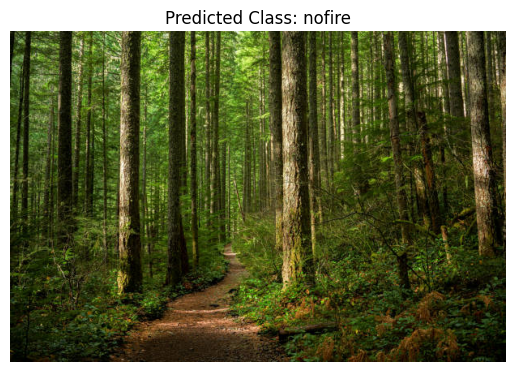

1/1 [==============================] - 0s 26ms/step


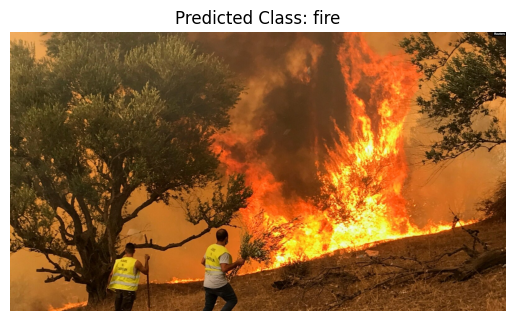

In [13]:
predict_images()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 111, 111, 128)    512       
 hNormalization)                                                 
                                                        

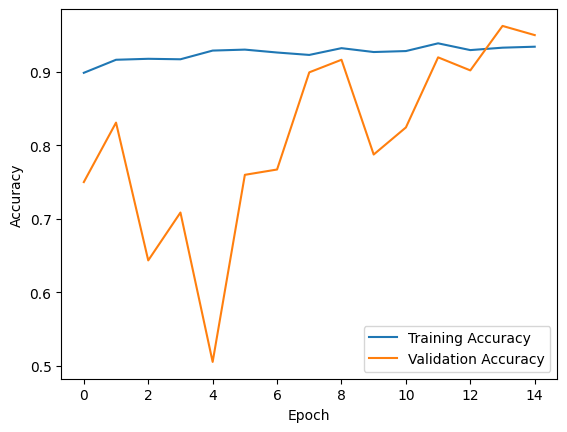

In [15]:
plot_accuracy(history)

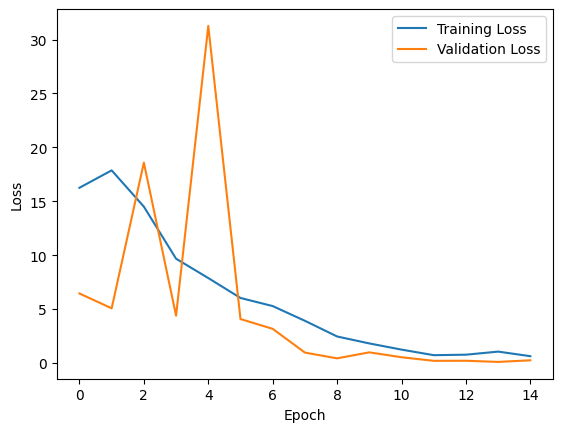

In [16]:
plot_loss(history)

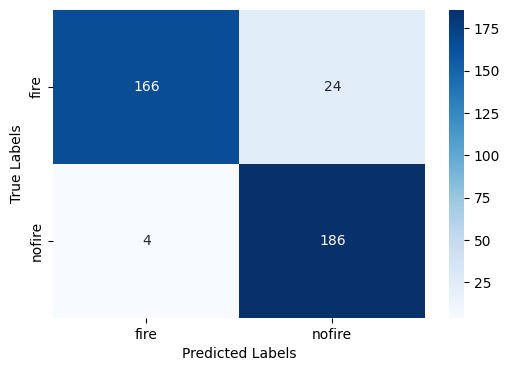

In [17]:
plot_confusion_matrix(confusion, class_names)